In [1]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
 
import pandas as pd, xgboost, numpy, textblob, string, lightgbm
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import nltk
import numpy as np

/Users/wallace/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.externals import joblib
%matplotlib inline
import seaborn as sn
from tqdm import tqdm_notebook as tqdm
from scipy.stats import skew, kurtosis, iqr
from sklearn.decomposition import TruncatedSVD

/Users/wallace/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
train_df = pd.read_csv('train_metanew_nb_svd200_word2vec.csv')

In [4]:
test_df = pd.read_csv('test_metanew_nb_svd200_word2vec.csv')

In [5]:
feats = [f for f in train_df.columns if f not in ['label','text']]

In [6]:
feats

['num_words',
 'num_unique_words',
 'num_chars',
 'num_stopwords',
 'num_punctuations',
 'num_words_upper',
 'num_words_title',
 'mean_word_len',
 'word_density',
 'noun_count',
 'verb_count',
 'adj_count',
 'adv_count',
 'pron_count',
 'unique_words_fraction',
 'stopwords_fraction',
 'punctuations_fraction',
 'words_upper_fraction',
 'words_title_fraction',
 'noun_count_fraction',
 'verb_count_fraction',
 'adj_count_fraction',
 'adv_count_fraction',
 'pron_count_fraction',
 'nb_word_tfidf_0',
 'nb_word_tfidf_1',
 'svd_word_tfidf0',
 'svd_word_tfidf1',
 'svd_word_tfidf2',
 'svd_word_tfidf3',
 'svd_word_tfidf4',
 'svd_word_tfidf5',
 'svd_word_tfidf6',
 'svd_word_tfidf7',
 'svd_word_tfidf8',
 'svd_word_tfidf9',
 'svd_word_tfidf10',
 'svd_word_tfidf11',
 'svd_word_tfidf12',
 'svd_word_tfidf13',
 'svd_word_tfidf14',
 'svd_word_tfidf15',
 'svd_word_tfidf16',
 'svd_word_tfidf17',
 'svd_word_tfidf18',
 'svd_word_tfidf19',
 'svd_word_tfidf20',
 'svd_word_tfidf21',
 'svd_word_tfidf22',
 'svd_wo

In [7]:
import lightgbm as lgb

In [8]:
train_df.shape

(416768, 1538)

In [9]:
test_df.shape

(119092, 1538)

In [10]:
folds = KFold(n_splits= 5, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()
    
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['label'])):
    dtrain = lgb.Dataset(data=train_df[feats].iloc[train_idx], 
                         label=train_df['label'].iloc[train_idx],
                         feature_name=feats)
    dvalid = lgb.Dataset(data=train_df[feats].iloc[valid_idx],
                         label=train_df['label'].iloc[valid_idx],
                         feature_name=feats)
    params = {'boosting_type': 'gbdt',
              'objective': 'binary',
              'metric':'auc',
              'learning_rate': 0.01,
              'num_leaves': 63, 
              'max_depth': 6,  
              #'min_child_samples': 70,  
              'max_bin': 255,  
              'subsample': 0.9,  
              #'subsample_freq': 1,  
              'colsample_bytree': 0.9,  
              #'min_split_gain': 0.5,
              'min_child_weight': 10,
              'min_data_in_leaf': 150,
              'reg_lambda': 0.5,
              'reg_alpha': 0.5,
              #'scale_pos_weight':1, 
              #'is_balance': False,
              #'nthread': 8,
              'bagging_freq': 1,
              'verbose': -1,}
    
    clf = lgb.train(params, 
                      dtrain, 
                      valid_sets=[dtrain, dvalid], 
                      valid_names=['train','valid'],
                      num_boost_round=1000000,
                      early_stopping_rounds=200,
                      verbose_eval=50)

    oof_preds[valid_idx] = clf.predict(train_df[feats].iloc[valid_idx])
    sub_preds += clf.predict(test_df[feats]) / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(train_df['label'].iloc[valid_idx], oof_preds[valid_idx])))
    del clf, dtrain, dvalid
    gc.collect()

print('Full AUC score %.6f' % roc_auc_score(train_df['label'], oof_preds))
    # Write submission file and plot feature importance
sub_df = test_df[['id']].copy()
sub_df['label'] = sub_preds
sub_df[['id', 'label']].to_csv('20191109submission_newpar_1538feature_01_prob.csv', index= False)

Training until validation scores don't improve for 200 rounds.
[50]	train's auc: 0.77386	valid's auc: 0.773828
[100]	train's auc: 0.779104	valid's auc: 0.778647
[150]	train's auc: 0.782856	valid's auc: 0.782065
[200]	train's auc: 0.786433	valid's auc: 0.785221
[250]	train's auc: 0.789783	valid's auc: 0.788016
[300]	train's auc: 0.792606	valid's auc: 0.790219
[350]	train's auc: 0.795161	valid's auc: 0.792176
[400]	train's auc: 0.797556	valid's auc: 0.793871
[450]	train's auc: 0.80001	valid's auc: 0.79548
[500]	train's auc: 0.80235	valid's auc: 0.796913
[550]	train's auc: 0.804579	valid's auc: 0.798236
[600]	train's auc: 0.806715	valid's auc: 0.799432
[650]	train's auc: 0.808853	valid's auc: 0.800552
[700]	train's auc: 0.810912	valid's auc: 0.801635
[750]	train's auc: 0.812859	valid's auc: 0.80264
[800]	train's auc: 0.814845	valid's auc: 0.803623
[850]	train's auc: 0.816634	valid's auc: 0.804443
[900]	train's auc: 0.818531	valid's auc: 0.805308
[950]	train's auc: 0.820259	valid's auc: 0.

[8100]	train's auc: 0.938326	valid's auc: 0.837349
[8150]	train's auc: 0.938833	valid's auc: 0.837442
[8200]	train's auc: 0.939307	valid's auc: 0.837539
[8250]	train's auc: 0.939804	valid's auc: 0.837643
[8300]	train's auc: 0.94026	valid's auc: 0.837732
[8350]	train's auc: 0.94073	valid's auc: 0.837815
[8400]	train's auc: 0.941156	valid's auc: 0.837893
[8450]	train's auc: 0.941583	valid's auc: 0.837946
[8500]	train's auc: 0.94207	valid's auc: 0.838019
[8550]	train's auc: 0.942491	valid's auc: 0.838103
[8600]	train's auc: 0.942944	valid's auc: 0.838175
[8650]	train's auc: 0.943364	valid's auc: 0.838258
[8700]	train's auc: 0.9438	valid's auc: 0.838336
[8750]	train's auc: 0.944227	valid's auc: 0.838406
[8800]	train's auc: 0.944636	valid's auc: 0.838496
[8850]	train's auc: 0.945041	valid's auc: 0.83857
[8900]	train's auc: 0.945476	valid's auc: 0.838646
[8950]	train's auc: 0.94592	valid's auc: 0.838718
[9000]	train's auc: 0.946323	valid's auc: 0.838777
[9050]	train's auc: 0.946735	valid's a

[16100]	train's auc: 0.98325	valid's auc: 0.845318
[16150]	train's auc: 0.983386	valid's auc: 0.845341
[16200]	train's auc: 0.983538	valid's auc: 0.845376
[16250]	train's auc: 0.983689	valid's auc: 0.8454
[16300]	train's auc: 0.983821	valid's auc: 0.84543
[16350]	train's auc: 0.983956	valid's auc: 0.845461
[16400]	train's auc: 0.984097	valid's auc: 0.845491
[16450]	train's auc: 0.984255	valid's auc: 0.845526
[16500]	train's auc: 0.984386	valid's auc: 0.845539
[16550]	train's auc: 0.984526	valid's auc: 0.84557
[16600]	train's auc: 0.984646	valid's auc: 0.845595
[16650]	train's auc: 0.984783	valid's auc: 0.845621
[16700]	train's auc: 0.984912	valid's auc: 0.845648
[16750]	train's auc: 0.985041	valid's auc: 0.84568
[16800]	train's auc: 0.985182	valid's auc: 0.845707
[16850]	train's auc: 0.985313	valid's auc: 0.845724
[16900]	train's auc: 0.985438	valid's auc: 0.845747
[16950]	train's auc: 0.985571	valid's auc: 0.845772
[17000]	train's auc: 0.985702	valid's auc: 0.845794
[17050]	train's au

[24050]	train's auc: 0.996001	valid's auc: 0.848149
[24100]	train's auc: 0.99604	valid's auc: 0.848158
[24150]	train's auc: 0.996073	valid's auc: 0.848171
[24200]	train's auc: 0.996109	valid's auc: 0.848176
[24250]	train's auc: 0.996147	valid's auc: 0.848189
[24300]	train's auc: 0.996181	valid's auc: 0.84821
[24350]	train's auc: 0.996212	valid's auc: 0.848215
[24400]	train's auc: 0.996244	valid's auc: 0.848223
[24450]	train's auc: 0.996277	valid's auc: 0.848222
[24500]	train's auc: 0.99631	valid's auc: 0.848237
[24550]	train's auc: 0.996346	valid's auc: 0.848255
[24600]	train's auc: 0.996381	valid's auc: 0.848277
[24650]	train's auc: 0.996413	valid's auc: 0.848284
[24700]	train's auc: 0.996444	valid's auc: 0.848288
[24750]	train's auc: 0.996476	valid's auc: 0.848294
[24800]	train's auc: 0.996508	valid's auc: 0.848308
[24850]	train's auc: 0.996538	valid's auc: 0.848316
[24900]	train's auc: 0.99657	valid's auc: 0.848324
[24950]	train's auc: 0.9966	valid's auc: 0.848343
[25000]	train's au

[32000]	train's auc: 0.99892	valid's auc: 0.849368
[32050]	train's auc: 0.998928	valid's auc: 0.849376
[32100]	train's auc: 0.998935	valid's auc: 0.849372
[32150]	train's auc: 0.998943	valid's auc: 0.84938
[32200]	train's auc: 0.998951	valid's auc: 0.849385
[32250]	train's auc: 0.998957	valid's auc: 0.849397
[32300]	train's auc: 0.998966	valid's auc: 0.849405
[32350]	train's auc: 0.998973	valid's auc: 0.849414
[32400]	train's auc: 0.99898	valid's auc: 0.849426
[32450]	train's auc: 0.998987	valid's auc: 0.849439
[32500]	train's auc: 0.998994	valid's auc: 0.849442
[32550]	train's auc: 0.999001	valid's auc: 0.849449
[32600]	train's auc: 0.999008	valid's auc: 0.849454
[32650]	train's auc: 0.999015	valid's auc: 0.849462
[32700]	train's auc: 0.999023	valid's auc: 0.849469
[32750]	train's auc: 0.99903	valid's auc: 0.849469
[32800]	train's auc: 0.999036	valid's auc: 0.849471
[32850]	train's auc: 0.999043	valid's auc: 0.849476
[32900]	train's auc: 0.999049	valid's auc: 0.849475
[32950]	train's 

[5250]	train's auc: 0.906754	valid's auc: 0.829132
[5300]	train's auc: 0.9074	valid's auc: 0.829282
[5350]	train's auc: 0.908102	valid's auc: 0.829428
[5400]	train's auc: 0.908772	valid's auc: 0.829586
[5450]	train's auc: 0.909488	valid's auc: 0.829732
[5500]	train's auc: 0.91014	valid's auc: 0.829865
[5550]	train's auc: 0.910822	valid's auc: 0.830009
[5600]	train's auc: 0.911445	valid's auc: 0.830136
[5650]	train's auc: 0.91208	valid's auc: 0.830272
[5700]	train's auc: 0.912709	valid's auc: 0.830413
[5750]	train's auc: 0.91335	valid's auc: 0.830571
[5800]	train's auc: 0.913961	valid's auc: 0.83069
[5850]	train's auc: 0.914592	valid's auc: 0.830838
[5900]	train's auc: 0.91521	valid's auc: 0.830967
[5950]	train's auc: 0.915823	valid's auc: 0.83111
[6000]	train's auc: 0.916441	valid's auc: 0.831242
[6050]	train's auc: 0.917028	valid's auc: 0.831366
[6100]	train's auc: 0.917632	valid's auc: 0.831488
[6150]	train's auc: 0.918222	valid's auc: 0.83159
[6200]	train's auc: 0.918849	valid's auc

[13300]	train's auc: 0.973015	valid's auc: 0.841925
[13350]	train's auc: 0.973243	valid's auc: 0.841959
[13400]	train's auc: 0.97346	valid's auc: 0.841988
[13450]	train's auc: 0.973693	valid's auc: 0.842038
[13500]	train's auc: 0.973897	valid's auc: 0.84209
[13550]	train's auc: 0.974116	valid's auc: 0.842143
[13600]	train's auc: 0.97431	valid's auc: 0.842179
[13650]	train's auc: 0.974532	valid's auc: 0.842223
[13700]	train's auc: 0.974753	valid's auc: 0.842277
[13750]	train's auc: 0.974945	valid's auc: 0.842311
[13800]	train's auc: 0.97516	valid's auc: 0.842348
[13850]	train's auc: 0.975358	valid's auc: 0.842382
[13900]	train's auc: 0.975566	valid's auc: 0.842418
[13950]	train's auc: 0.975765	valid's auc: 0.842449
[14000]	train's auc: 0.975965	valid's auc: 0.842488
[14050]	train's auc: 0.976155	valid's auc: 0.842527
[14100]	train's auc: 0.976381	valid's auc: 0.842589
[14150]	train's auc: 0.976578	valid's auc: 0.842622
[14200]	train's auc: 0.976767	valid's auc: 0.842653
[14250]	train's 

[21250]	train's auc: 0.993335	valid's auc: 0.8461
[21300]	train's auc: 0.993395	valid's auc: 0.84611
[21350]	train's auc: 0.993452	valid's auc: 0.846137
[21400]	train's auc: 0.99351	valid's auc: 0.846165
[21450]	train's auc: 0.993575	valid's auc: 0.846177
[21500]	train's auc: 0.993631	valid's auc: 0.846188
[21550]	train's auc: 0.99369	valid's auc: 0.846204
[21600]	train's auc: 0.993743	valid's auc: 0.846218
[21650]	train's auc: 0.993798	valid's auc: 0.846229
[21700]	train's auc: 0.993859	valid's auc: 0.846232
[21750]	train's auc: 0.993916	valid's auc: 0.846249
[21800]	train's auc: 0.993977	valid's auc: 0.846263
[21850]	train's auc: 0.994032	valid's auc: 0.846281
[21900]	train's auc: 0.99408	valid's auc: 0.846283
[21950]	train's auc: 0.994129	valid's auc: 0.846295
[22000]	train's auc: 0.994185	valid's auc: 0.846317
[22050]	train's auc: 0.994239	valid's auc: 0.846332
[22100]	train's auc: 0.994294	valid's auc: 0.846343
[22150]	train's auc: 0.994341	valid's auc: 0.846349
[22200]	train's au

[29200]	train's auc: 0.998346	valid's auc: 0.847542
[29250]	train's auc: 0.99836	valid's auc: 0.847542
[29300]	train's auc: 0.998372	valid's auc: 0.847557
[29350]	train's auc: 0.998384	valid's auc: 0.847551
[29400]	train's auc: 0.998396	valid's auc: 0.847553
[29450]	train's auc: 0.99841	valid's auc: 0.847555
[29500]	train's auc: 0.998419	valid's auc: 0.847562
[29550]	train's auc: 0.99843	valid's auc: 0.847571
[29600]	train's auc: 0.998442	valid's auc: 0.847583
[29650]	train's auc: 0.998454	valid's auc: 0.847583
[29700]	train's auc: 0.998465	valid's auc: 0.847593
[29750]	train's auc: 0.998477	valid's auc: 0.84761
[29800]	train's auc: 0.998489	valid's auc: 0.847618
[29850]	train's auc: 0.998501	valid's auc: 0.847618
[29900]	train's auc: 0.998512	valid's auc: 0.84762
[29950]	train's auc: 0.998523	valid's auc: 0.847622
[30000]	train's auc: 0.998536	valid's auc: 0.847622
[30050]	train's auc: 0.998547	valid's auc: 0.847627
[30100]	train's auc: 0.998559	valid's auc: 0.847625
[30150]	train's a

[6000]	train's auc: 0.916237	valid's auc: 0.831311
[6050]	train's auc: 0.916847	valid's auc: 0.831452
[6100]	train's auc: 0.917428	valid's auc: 0.83158
[6150]	train's auc: 0.918028	valid's auc: 0.831715
[6200]	train's auc: 0.918605	valid's auc: 0.831833
[6250]	train's auc: 0.919175	valid's auc: 0.831961
[6300]	train's auc: 0.919754	valid's auc: 0.832063
[6350]	train's auc: 0.920342	valid's auc: 0.832179
[6400]	train's auc: 0.920923	valid's auc: 0.832308
[6450]	train's auc: 0.921482	valid's auc: 0.832439
[6500]	train's auc: 0.922064	valid's auc: 0.832561
[6550]	train's auc: 0.922653	valid's auc: 0.832672
[6600]	train's auc: 0.923218	valid's auc: 0.832794
[6650]	train's auc: 0.923765	valid's auc: 0.832915
[6700]	train's auc: 0.924293	valid's auc: 0.833039
[6750]	train's auc: 0.924857	valid's auc: 0.833159
[6800]	train's auc: 0.925455	valid's auc: 0.833277
[6850]	train's auc: 0.925997	valid's auc: 0.833386
[6900]	train's auc: 0.92653	valid's auc: 0.833498
[6950]	train's auc: 0.92706	valid

[14000]	train's auc: 0.976177	valid's auc: 0.842946
[14050]	train's auc: 0.976372	valid's auc: 0.842972
[14100]	train's auc: 0.976569	valid's auc: 0.84302
[14150]	train's auc: 0.976779	valid's auc: 0.843055
[14200]	train's auc: 0.97698	valid's auc: 0.843094
[14250]	train's auc: 0.977158	valid's auc: 0.843134
[14300]	train's auc: 0.977362	valid's auc: 0.843169
[14350]	train's auc: 0.977563	valid's auc: 0.8432
[14400]	train's auc: 0.977757	valid's auc: 0.843231
[14450]	train's auc: 0.977947	valid's auc: 0.843264
[14500]	train's auc: 0.978132	valid's auc: 0.843288
[14550]	train's auc: 0.978327	valid's auc: 0.843332
[14600]	train's auc: 0.978515	valid's auc: 0.843373
[14650]	train's auc: 0.978692	valid's auc: 0.843411
[14700]	train's auc: 0.978875	valid's auc: 0.843442
[14750]	train's auc: 0.979039	valid's auc: 0.843463
[14800]	train's auc: 0.979199	valid's auc: 0.843481
[14850]	train's auc: 0.979371	valid's auc: 0.843522
[14900]	train's auc: 0.979552	valid's auc: 0.843565
[14950]	train's 

[21950]	train's auc: 0.994181	valid's auc: 0.846827
[22000]	train's auc: 0.994229	valid's auc: 0.846838
[22050]	train's auc: 0.994284	valid's auc: 0.846854
[22100]	train's auc: 0.994333	valid's auc: 0.846869
[22150]	train's auc: 0.994386	valid's auc: 0.846881
[22200]	train's auc: 0.994434	valid's auc: 0.846897
[22250]	train's auc: 0.994489	valid's auc: 0.846917
[22300]	train's auc: 0.994538	valid's auc: 0.846926
[22350]	train's auc: 0.994587	valid's auc: 0.846938
[22400]	train's auc: 0.994636	valid's auc: 0.846958
[22450]	train's auc: 0.994684	valid's auc: 0.846968
[22500]	train's auc: 0.994732	valid's auc: 0.846995
[22550]	train's auc: 0.994783	valid's auc: 0.847004
[22600]	train's auc: 0.994834	valid's auc: 0.847011
[22650]	train's auc: 0.994878	valid's auc: 0.847009
[22700]	train's auc: 0.994923	valid's auc: 0.847029
[22750]	train's auc: 0.994969	valid's auc: 0.847035
[22800]	train's auc: 0.995015	valid's auc: 0.847036
[22850]	train's auc: 0.995055	valid's auc: 0.847034
[22900]	trai

[29900]	train's auc: 0.998557	valid's auc: 0.848224
[29950]	train's auc: 0.998568	valid's auc: 0.848234
[30000]	train's auc: 0.998579	valid's auc: 0.848237
[30050]	train's auc: 0.998588	valid's auc: 0.848245
[30100]	train's auc: 0.998599	valid's auc: 0.84824
[30150]	train's auc: 0.99861	valid's auc: 0.848251
[30200]	train's auc: 0.998622	valid's auc: 0.848262
[30250]	train's auc: 0.998632	valid's auc: 0.848262
[30300]	train's auc: 0.998643	valid's auc: 0.848265
[30350]	train's auc: 0.998654	valid's auc: 0.848268
[30400]	train's auc: 0.998664	valid's auc: 0.84828
[30450]	train's auc: 0.998674	valid's auc: 0.848281
[30500]	train's auc: 0.998684	valid's auc: 0.848286
[30550]	train's auc: 0.998693	valid's auc: 0.848294
[30600]	train's auc: 0.998703	valid's auc: 0.8483
[30650]	train's auc: 0.998712	valid's auc: 0.84831
[30700]	train's auc: 0.998722	valid's auc: 0.84832
[30750]	train's auc: 0.99873	valid's auc: 0.848322
[30800]	train's auc: 0.998741	valid's auc: 0.84832
[30850]	train's auc: 

[5250]	train's auc: 0.906736	valid's auc: 0.829371
[5300]	train's auc: 0.907356	valid's auc: 0.829515
[5350]	train's auc: 0.908062	valid's auc: 0.829677
[5400]	train's auc: 0.908723	valid's auc: 0.829844
[5450]	train's auc: 0.909329	valid's auc: 0.829983
[5500]	train's auc: 0.909984	valid's auc: 0.830118
[5550]	train's auc: 0.91063	valid's auc: 0.830243
[5600]	train's auc: 0.911261	valid's auc: 0.830377
[5650]	train's auc: 0.9119	valid's auc: 0.830525
[5700]	train's auc: 0.912544	valid's auc: 0.830676
[5750]	train's auc: 0.913164	valid's auc: 0.830801
[5800]	train's auc: 0.913817	valid's auc: 0.830931
[5850]	train's auc: 0.914463	valid's auc: 0.831066
[5900]	train's auc: 0.915072	valid's auc: 0.831214
[5950]	train's auc: 0.915672	valid's auc: 0.831339
[6000]	train's auc: 0.9163	valid's auc: 0.831477
[6050]	train's auc: 0.916873	valid's auc: 0.831589
[6100]	train's auc: 0.917483	valid's auc: 0.831729
[6150]	train's auc: 0.918096	valid's auc: 0.831869
[6200]	train's auc: 0.918762	valid's

[13300]	train's auc: 0.972958	valid's auc: 0.843161
[13350]	train's auc: 0.973158	valid's auc: 0.843202
[13400]	train's auc: 0.973403	valid's auc: 0.843245
[13450]	train's auc: 0.973605	valid's auc: 0.843281
[13500]	train's auc: 0.973806	valid's auc: 0.843326
[13550]	train's auc: 0.974018	valid's auc: 0.843372
[13600]	train's auc: 0.974234	valid's auc: 0.843419
[13650]	train's auc: 0.974449	valid's auc: 0.843461
[13700]	train's auc: 0.974653	valid's auc: 0.843504
[13750]	train's auc: 0.974868	valid's auc: 0.843549
[13800]	train's auc: 0.975066	valid's auc: 0.843595
[13850]	train's auc: 0.975265	valid's auc: 0.843635
[13900]	train's auc: 0.975473	valid's auc: 0.843674
[13950]	train's auc: 0.975678	valid's auc: 0.843712
[14000]	train's auc: 0.975891	valid's auc: 0.843751
[14050]	train's auc: 0.97611	valid's auc: 0.843788
[14100]	train's auc: 0.976304	valid's auc: 0.843814
[14150]	train's auc: 0.976505	valid's auc: 0.84385
[14200]	train's auc: 0.976702	valid's auc: 0.843885
[14250]	train'

[21250]	train's auc: 0.993278	valid's auc: 0.847661
[21300]	train's auc: 0.993337	valid's auc: 0.847671
[21350]	train's auc: 0.993399	valid's auc: 0.847688
[21400]	train's auc: 0.993454	valid's auc: 0.847712
[21450]	train's auc: 0.993521	valid's auc: 0.847736
[21500]	train's auc: 0.99358	valid's auc: 0.847756
[21550]	train's auc: 0.993642	valid's auc: 0.847773
[21600]	train's auc: 0.993702	valid's auc: 0.847795
[21650]	train's auc: 0.993759	valid's auc: 0.847801
[21700]	train's auc: 0.993813	valid's auc: 0.847816
[21750]	train's auc: 0.993865	valid's auc: 0.847832
[21800]	train's auc: 0.993918	valid's auc: 0.847844
[21850]	train's auc: 0.993979	valid's auc: 0.847866
[21900]	train's auc: 0.99403	valid's auc: 0.847881
[21950]	train's auc: 0.994082	valid's auc: 0.847891
[22000]	train's auc: 0.994139	valid's auc: 0.847915
[22050]	train's auc: 0.99419	valid's auc: 0.847927
[22100]	train's auc: 0.994244	valid's auc: 0.847938
[22150]	train's auc: 0.994293	valid's auc: 0.84796
[22200]	train's 

[29200]	train's auc: 0.998346	valid's auc: 0.849366
[29250]	train's auc: 0.99836	valid's auc: 0.849378
[29300]	train's auc: 0.998373	valid's auc: 0.849386
[29350]	train's auc: 0.998386	valid's auc: 0.84939
[29400]	train's auc: 0.998399	valid's auc: 0.849388
[29450]	train's auc: 0.998413	valid's auc: 0.849396
[29500]	train's auc: 0.998425	valid's auc: 0.849414
[29550]	train's auc: 0.998436	valid's auc: 0.849423
[29600]	train's auc: 0.998449	valid's auc: 0.849428
[29650]	train's auc: 0.998461	valid's auc: 0.849438
[29700]	train's auc: 0.998473	valid's auc: 0.849439
[29750]	train's auc: 0.998484	valid's auc: 0.849451
[29800]	train's auc: 0.998498	valid's auc: 0.849461
[29850]	train's auc: 0.998509	valid's auc: 0.849456
[29900]	train's auc: 0.99852	valid's auc: 0.849467
[29950]	train's auc: 0.998532	valid's auc: 0.849465
[30000]	train's auc: 0.998545	valid's auc: 0.849471
[30050]	train's auc: 0.998556	valid's auc: 0.849476
[30100]	train's auc: 0.998568	valid's auc: 0.849484
[30150]	train's

[5650]	train's auc: 0.912029	valid's auc: 0.833232
[5700]	train's auc: 0.912673	valid's auc: 0.833362
[5750]	train's auc: 0.913355	valid's auc: 0.83351
[5800]	train's auc: 0.913933	valid's auc: 0.833637
[5850]	train's auc: 0.914596	valid's auc: 0.833784
[5900]	train's auc: 0.915221	valid's auc: 0.833927
[5950]	train's auc: 0.915866	valid's auc: 0.834064
[6000]	train's auc: 0.916503	valid's auc: 0.834222
[6050]	train's auc: 0.917084	valid's auc: 0.834327
[6100]	train's auc: 0.91767	valid's auc: 0.834449
[6150]	train's auc: 0.918273	valid's auc: 0.834575
[6200]	train's auc: 0.91886	valid's auc: 0.834707
[6250]	train's auc: 0.919459	valid's auc: 0.834823
[6300]	train's auc: 0.920058	valid's auc: 0.83494
[6350]	train's auc: 0.920657	valid's auc: 0.835073
[6400]	train's auc: 0.921216	valid's auc: 0.835197
[6450]	train's auc: 0.921799	valid's auc: 0.835305
[6500]	train's auc: 0.922359	valid's auc: 0.835438
[6550]	train's auc: 0.922864	valid's auc: 0.835546
[6600]	train's auc: 0.923437	valid'

[13650]	train's auc: 0.974549	valid's auc: 0.844749
[13700]	train's auc: 0.974763	valid's auc: 0.844793
[13750]	train's auc: 0.974983	valid's auc: 0.844831
[13800]	train's auc: 0.975195	valid's auc: 0.84486
[13850]	train's auc: 0.975385	valid's auc: 0.844896
[13900]	train's auc: 0.975586	valid's auc: 0.844919
[13950]	train's auc: 0.975788	valid's auc: 0.844953
[14000]	train's auc: 0.97598	valid's auc: 0.844984
[14050]	train's auc: 0.976207	valid's auc: 0.845036
[14100]	train's auc: 0.9764	valid's auc: 0.845065
[14150]	train's auc: 0.976613	valid's auc: 0.845099
[14200]	train's auc: 0.976799	valid's auc: 0.845132
[14250]	train's auc: 0.976984	valid's auc: 0.845168
[14300]	train's auc: 0.977168	valid's auc: 0.845198
[14350]	train's auc: 0.977371	valid's auc: 0.84522
[14400]	train's auc: 0.977549	valid's auc: 0.845255
[14450]	train's auc: 0.977741	valid's auc: 0.845287
[14500]	train's auc: 0.977946	valid's auc: 0.845319
[14550]	train's auc: 0.978143	valid's auc: 0.845361
[14600]	train's a

[21600]	train's auc: 0.993732	valid's auc: 0.848125
[21650]	train's auc: 0.993785	valid's auc: 0.848129
[21700]	train's auc: 0.99384	valid's auc: 0.848128
[21750]	train's auc: 0.993895	valid's auc: 0.848135
[21800]	train's auc: 0.993956	valid's auc: 0.848143
[21850]	train's auc: 0.994011	valid's auc: 0.848149
[21900]	train's auc: 0.994059	valid's auc: 0.848151
[21950]	train's auc: 0.994112	valid's auc: 0.848159
[22000]	train's auc: 0.994173	valid's auc: 0.848172
[22050]	train's auc: 0.994227	valid's auc: 0.848175
[22100]	train's auc: 0.99428	valid's auc: 0.848198
[22150]	train's auc: 0.994329	valid's auc: 0.848212
[22200]	train's auc: 0.994376	valid's auc: 0.848226
[22250]	train's auc: 0.99443	valid's auc: 0.848236
[22300]	train's auc: 0.994477	valid's auc: 0.848239
[22350]	train's auc: 0.99453	valid's auc: 0.848253
[22400]	train's auc: 0.994585	valid's auc: 0.84827
[22450]	train's auc: 0.994642	valid's auc: 0.84828
[22500]	train's auc: 0.994686	valid's auc: 0.848284
[22550]	train's au

[29550]	train's auc: 0.998443	valid's auc: 0.849247
[29600]	train's auc: 0.998455	valid's auc: 0.849249
[29650]	train's auc: 0.998466	valid's auc: 0.849252
[29700]	train's auc: 0.998477	valid's auc: 0.849254
[29750]	train's auc: 0.99849	valid's auc: 0.84926
[29800]	train's auc: 0.998503	valid's auc: 0.849263
[29850]	train's auc: 0.998514	valid's auc: 0.849267
[29900]	train's auc: 0.998526	valid's auc: 0.849273
[29950]	train's auc: 0.998538	valid's auc: 0.849274
[30000]	train's auc: 0.998551	valid's auc: 0.849277
[30050]	train's auc: 0.998562	valid's auc: 0.849281
[30100]	train's auc: 0.998573	valid's auc: 0.84929
[30150]	train's auc: 0.998584	valid's auc: 0.84929
[30200]	train's auc: 0.998595	valid's auc: 0.849304
[30250]	train's auc: 0.998606	valid's auc: 0.849313
[30300]	train's auc: 0.998618	valid's auc: 0.849317
[30350]	train's auc: 0.998628	valid's auc: 0.849316
[30400]	train's auc: 0.998639	valid's auc: 0.849326
[30450]	train's auc: 0.99865	valid's auc: 0.849333
[30500]	train's a

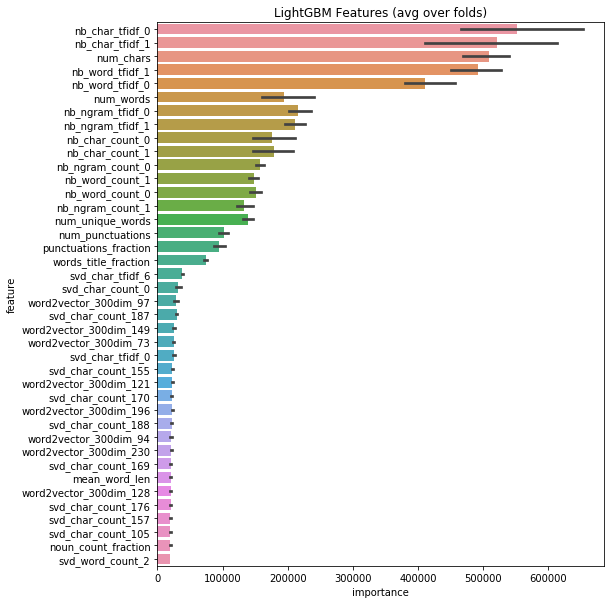

In [11]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout
plt.show()

In [12]:
firstLabel = sub_preds

In [13]:
ccc=0
for i in range(119092):
    if firstLabel[i]>0.5:
        ccc = ccc + 1

In [14]:
ccc

60490

In [15]:
for i in range(119092):
    if firstLabel[i]>=0.5:
        firstLabel[i]=1
    else:
        firstLabel[i]=0

In [16]:
sub_df = test_df[['id']].copy()
sub_df['Category'] = firstLabel
sub_df[['id', 'Category']].to_csv('20191109submission_newpar_1538feature_01.csv', index= False)

In [ ]:
###

In [ ]:
###opt

In [ ]:
             'learning_rate': 0.01,
              'num_leaves': 63, 
              'max_depth': 6,  
              #'min_child_samples': 70,  
              'max_bin': 255,  
              'subsample': 0.9,  
              #'subsample_freq': 1,  
              'colsample_bytree': 0.9,  
              #'min_split_gain': 0.5,
              'min_child_weight': 10,
              'min_data_in_leaf': 150,
              'reg_lambda': 0.5,
              'reg_alpha': 0.5,
              #'scale_pos_weight':1, 
              #'is_balance': False,
              #'nthread': 8,
              'bagging_freq': 1,

In [ ]:
def bayes_parameter_opt_lgb(X, y, init_round=10, opt_round=20, n_folds=5, random_seed=1001, n_estimators=100000, learning_rate=0.01, output_process=True):
    # prepare data
    train_data = lgb.Dataset(data=X, label=y, feature_name=feats, categorical_feature=categorical_columns, free_raw_data=False)
    # parameters
    def lgb_eval(num_leaves, colsample_bytree, subsample, max_depth, reg_lambda, reg_alpha, min_split_gain, min_child_weight, scale_pos_weight,
                min_child_sample, max_bin, subsample_freq):
        params = {'objective':'binary','boosting_type': 'gbdt', 'verbose': -1,\
                  'num_boost_round': n_estimators, 'learning_rate':learning_rate, \
                  'early_stopping_round':200, 'metric':'auc','is_balance': False}
        params['subsample_freq']=int(round(subsample_freq))
        params['min_child_sample']=int(round(min_child_sample))
        params['max_bin']=int(round(max_bin))
        params["num_leaves"] = int(round(num_leaves))
        params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
        params['subsample'] = max(min(subsample, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['reg_lambda'] = max(reg_lambda, 0)
        params['reg_alpha'] = max(reg_alpha, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        params['scale_pos_weight']= scale_pos_weight
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
        return max(cv_result['auc-mean'])
    # range 
    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (60, 65),
                                            'max_depth': (4, 8),
                                            'max_bin':(240,270),
                                            'subsample': (0.7, 1.2),
                                            'colsample_bytree': (0.7, 1.2),
                                            'min_child_weight': (7, 13),
                                            'reg_lambda': (0, 1),
                                            'reg_alpha': (0, 1),
                                            'min_child_sample':(60,80),
                                            
                                            'subsample_freq':(1,3),
                                            'min_split_gain': (0.3, 0.7),
                                            
                                           'scale_pos_weight':(0,4)})
    # optimize
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    # output optimization process
    if output_process==True: lgbBO.points_to_csv("bayes_opt_result.csv")
    
    # return best parameters
    return lgbBO.res['max']['max_params']

opt_params = bayes_parameter_opt_lgb(X, y, init_round=10, opt_round=20, n_folds=5, random_seed=1001, n_estimators=100000, learning_rate=0.01,output_process=True)